In [1]:
import numpy as np
import random
import copy
import math

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

num_drones = 8
drone_id = 0
population = []

In [2]:
class Drone:
    id = 0
    x = 0
    y = 0
    rely_on = []
    def __init__(self):
        global drone_id
        self.id = drone_id
        drone_id += 1
        self.rely_on = []
        

In [3]:
def vertices_of_regpoly(n, r):
    vertices = []
    x = []
    y = []
    for i in range(0, n):
        x.append(r * math.cos(2 * math.pi * i / n))
        y.append(r * math.sin(2 * math.pi * i / n))
    vertices.append(x)
    vertices.append(y)
    return vertices


In [4]:
def set_init_drones(swarm):
    xy = vertices_of_regpoly(num_drones, 1)
    for i in range(0, len(swarm.drones)):
        swarm.drones[i].x = xy[0][i]
        swarm.drones[i].y = xy[1][i]

In [5]:
class Swarm:
    drones = []
    connectedness = []
    def __init__(self, drones):
        self.drones = drones
        self.connectedness = assign_connectedness(drones)
        global drone_id
        drone_id = 0
        set_init_drones(self)
        
        
def assign_connectedness(drones):
    connectedness = np.zeros((len(drones),len(drones)))
    
    #The upper traingle of a mtrix w/o diagonal is filled in with 1s
    #the diagonal would mean drones are connected to themselves
    #the lower triangle is just a reflection
    #representation of the connections between drones
    for i in range(0,len(drones)):
        for j in range(0, i):
            connectedness[j][i] = 1 #if random.random() > 0.5 else 0
            #connectedness[i][j] = connectedness[j][i]
           
    # Ensure that each drone has at least one connection
    for i in range(0,len(drones)):
        possible_values = np.nonzero(connectedness[i])[0].tolist()
        choice = random.choice(possible_values) if possible_values else -1
        if choice != -1:
            possible_values.remove(choice)
        #Remaining choices have a possibility of not being connections (probability related to the number of drones)
        for value in possible_values:
            connectedness[i][value] = 0 if random.random() > 1.0/float(len(drones)) else 1

    #reflect over diagonal axis of matrix to make symmetric matrix
    for i in range(0,len(drones)):
        for j in range(0, i):
            connectedness[i][j] = connectedness[j][i]
    
    for i in range(0,len(drones)):
        for j in range(0, len(drones)):
            if connectedness[i][j] == 1:
                drones[i].rely_on.append(j)
            
    return connectedness
            
        

In [6]:
def create_starting_population(size):
    population = []
    
    global num_nodes
    for i in range(0,size):
        population.append(create_new_member(num_drones))
        
    return population

In [7]:
def create_new_member(num_drones):
    drones = []
    for i in range(0, num_drones):
        drones.append(Drone())
    member = Swarm(drones)
    return member

In [8]:
def plot_swarm(swarm):
    fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
    for drone in swarm.drones:
        plt.plot(drone.x, drone.y, 'x', color='black')
        
        circle1 = plt.Circle((drone.x, drone.y), 10, color = 'b', fill=False)        
        ax.add_artist(circle1)

    #fig.savefig('plotcircles.png')
        
    for row in range(0, num_drones - 1):
        for col in range(row + 1, num_drones):
            if swarm.connectedness[row][col] == 1:
                plt.plot([swarm.drones[row].x, swarm.drones[col].x], 
                         [swarm.drones[row].y, swarm.drones[col].y])
    set_map(100)
    
def set_map(map_size):
    map_size /=2
    plt.plot([-map_size,-map_size, map_size, map_size, -map_size], 
             [-map_size, map_size, map_size,-map_size, -map_size])
    


In [9]:
def drone_distance(drone1, drone2):
    return math.hypot(drone2.x - drone1.x, drone2.y - drone1.y)

In [10]:
def drone_sig_strength(drone_dist):
    return 1/math.pow(drone_dist,2)

In [11]:
def swarm_sig_strength(swarm):
    swarm_strength = []
    
    for i in range(0, num_drones):
        for j in range(0, i):
            if swarm.connectedness[i][j] == 1:
                #print('Signal strength between drone ', i, ' and drone ', j, ': ', end='')
                #print(drone_sig_strength(swarm.drones[i], swarm.drones[j]))
                dist = drone_distance(swarm.drones[i], swarm.drones[j])
                swarm_strength.append([[j, i], dist , drone_sig_strength(dist)])
    return swarm_strength

[[[0, 2], 1.414213562373095, 0.5000000000000001], [[1, 2], 0.7653668647301795, 1.707106781186548], [[0, 3], 1.8477590650225735, 0.2928932188134525], [[3, 4], 0.7653668647301795, 1.707106781186548], [[0, 5], 1.8477590650225737, 0.2928932188134524], [[3, 5], 1.414213562373095, 0.5000000000000001], [[4, 5], 0.7653668647301796, 1.7071067811865475], [[2, 7], 1.8477590650225737, 0.2928932188134524], [[4, 7], 1.8477590650225735, 0.2928932188134525], [[5, 7], 1.414213562373095, 0.5000000000000001], [[6, 7], 0.7653668647301796, 1.7071067811865475]]


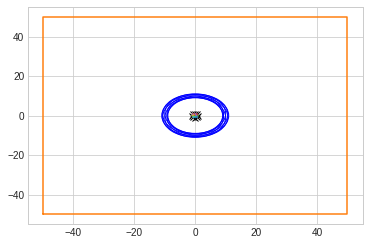

In [12]:
population = create_starting_population(1)
for swarm in population:
    plot_swarm(swarm)
    
    print(swarm_sig_strength(swarm))

[[[0, 2], 13.738805689909393, 0.005297879028773875], [[1, 2], 23.88907298623997, 0.0017522715322338762], [[0, 3], 25.668542728212536, 0.0015177406754446484], [[3, 4], 34.059034644931415, 0.0008620557069929795], [[0, 5], 41.090164802370644, 0.0005922761351590121], [[3, 5], 65.8394148602997, 0.0002306896313573598], [[4, 5], 85.0580553640268, 0.00013821943109284835], [[2, 7], 46.96615500123002, 0.00045334620636854273], [[4, 7], 65.88754603580797, 0.00023035271464784515], [[5, 7], 39.08910934358371, 0.0006544680500869391], [[6, 7], 71.8937668186142, 0.00019347173332008198]]


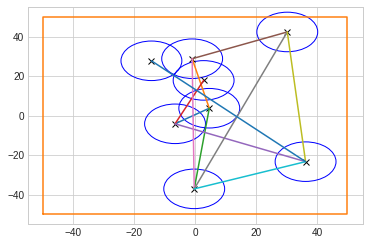

In [13]:
for swarm in population:
    for drone in swarm.drones:
        for i in range(0, 3000):
            drone.x += random.random() - .5
            drone.y += random.random() - .5
    plot_swarm(swarm)

    print(swarm_sig_strength(swarm))